In [1]:
#imports
from mesa import Agent, Model
import random
from mesa.time import RandomActivation
import copy
import matplotlib.pyplot as plt
import statistics


In [2]:
#setting up variables
maxresources = 100000   #the total number of microbe foods that can be used in the model
unusedfoods = []  #the pool of all potential foods that could be used as biproducts by an agent but have not yet been used
for i in range(maxresources):    #randomizes the order in which the foods are chosen
    unusedfoods.append(i)
random.shuffle(unusedfoods)

usedfoods = [maxresources]    #the pool of all foods that have been used as a biproduct
usedfoodspercent = {maxresources: 0}   #(resource number : how much of it has been used)
5.
fitness = 0.0    #the fitness of a given agent (determines how well it will compete with another microbe that eats the same food)

agentfitnessdict = {}    #agentname : fitness, WhatIEat, WhatIProduce    for all agents
agentpoplist = []    #the list for which each element is the population of the model at a given tick

agentfitnesslist = []   #the list of the average fitness of all microbes each tick for one trial

collapselist = []    #the list that containing the number of species lost each tick for all trials

outputlist = []    #the list of the amount of biproduct produced by each microbe




In [3]:
class MicrobeAgent(Agent):   #Everything that each individual microbe does
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)   
        self.fitness = random.random()   #the fitness of this microbe (a number betwenn 0 and 1)
        self.WhatIEat = random.choice(usedfoods)   #the single biproduct number that this microbe eats
        self.WhatIProduce = [unusedfoods[0], unusedfoods[1]]   #the two biproducts this microbe produces
        self.HowMuchIEat = (random.random() / 2) + 0.25   #what amount of the given resource this microbe eats from .25 to .75
        unusedfoods.pop(0)    #removing the foods this microbe produces
        unusedfoods.pop(0)
        usedfoods.append(self.WhatIProduce[0])   #adding the food this microbe produces
        usedfoods.append(self.WhatIProduce[1])
        if self.WhatIEat in list(usedfoodspercent.keys()):   #updating how much of the resource that this microbe eats has been used
            usedfoodspercent[self.WhatIEat] += self.HowMuchIEat
        else:
            usedfoodspercent[self.WhatIEat] = self.HowMuchIEat
        
        if self.WhatIEat == maxresources:   #sets up the amount of resource available to the first microbe in the "tree"
            self.outputamount = 1
        else:
            for element in agentfitnessdict:   #makes the amount of this resource that is available = a percentage of the amount of the "mother" resource (the resource that feeds the microbe that produces this resource)
                if agentfitnessdict[element][2][0] == self.WhatIEat or agentfitnessdict[element][2][1] == self.WhatIEat:
                    self.outputamount = (0.8 * element.outputamount)   #self.outputamount is the amount of resource that this microbe eats that is available
    def step(self):
        pass

class MicrobeModel(Model):
    def __init__(self):
        self.speciesID = -1    #the ID of a given species(starts at 0 and increases by 1 for each species)
        self.schedule = RandomActivation(self) #the order in which each microbe activates
        self.agentlist = []    #the list of all current agents
        self.tickcounter = 0   #the current tick
        
    def step(self):
        self.tickcounter += 1 
        self.speciesID += 1
        a = MicrobeAgent(self.speciesID, self)    #creates and initializes one new microbe each tick/step
        self.agentlist.append(a)   #adds the newly created microbe to all lists and dicts that hold data on each agent
        self.schedule.add(a)
        agentfitnessdict[self.agentlist[-1]] = [self.agentlist[-1].fitness, self.agentlist[-1].WhatIEat, self.agentlist[-1].WhatIProduce]
        
        self.restarti = True   #looks for competing microbes
        while self.restarti == True:
            self.restarti = False
            for i in range(len(self.agentlist) - 1):
                compare = self.agentlist[i]
                MicrobeModel.compare(self, compare, i)    #if it finds one it runs the "compare" code below
                if self.restarti == True:
                    break
        
        self.checkagain = True   #looks to see if any other microbes no longer have a food source if one goes extinct and removes that microbe if this is the case
        self.collapsesize = 0
        while self.checkagain == True:
            self.checkagain = False
            self.copiedagentlist = copy.copy(self.agentlist)
            for i in range(len(self.copiedagentlist)):
                self.agentchecking = self.copiedagentlist[i]
                if not self.agentchecking.WhatIEat in usedfoods:
                    self.collapsesize += 1
                    self.agentlist.pop(i)
                    agentfitnessdict.pop(self.copiedagentlist[i])
                    self.schedule.remove(self.agentchecking)
                    usedfoods.remove(self.agentchecking.WhatIProduce[0])
                    usedfoods.remove(self.agentchecking.WhatIProduce[1])
                    self.checkagain = True
                if self.checkagain == True:
                    break
        collapselist.append(self.collapsesize)    #records the number of species lost this tick
        agentpoplist.append(len(self.agentlist))    #records the population of the model this tick
        
        self.schedule.step()    #all agents take a step in the order detemined by schedule
        
        self.meanlist = []    #records the average fitness of all microbes this tick
        for i in range(len(self.agentlist)):
            self.meanlist.append(self.agentlist[i].fitness)
        agentfitnesslist.append(statistics.mean(self.meanlist))
        
        self.outputmean = []    #records the average amount of biproduct produced per biproduct this tick
        for i in self.agentlist:
            self.outputmean.append(i.outputamount)
        outputlist.append(statistics.mean(self.outputmean))
            
        
        
        
    def compare(self, comp2, num2):    #compares two or more microbes that eat the same resource and kills off one or more if necessary
        comp1 = self.agentlist[-1]
        num1 = len(self.agentlist) - 1
        if comp1.WhatIEat == comp2.WhatIEat and usedfoodspercent[comp1.WhatIEat] > comp1.outputamount:
            self.largerthan1 = True
            while self.largerthan1 == True:
                self.competitors = [x for x in agentfitnessdict if agentfitnessdict[x][1] == comp1.WhatIEat]
                self.competitorfit = {}
                for i in range(len(self.competitors)):
                    self.competitorfit[self.competitors[i].fitness] = self.competitors[i]
                self.toremove = self.competitorfit[min(self.competitorfit.keys())]
                self.agentlist.remove(self.toremove)
                self.schedule.remove(self.toremove)
                usedfoods.remove(self.toremove.WhatIProduce[0])
                usedfoods.remove(self.toremove.WhatIProduce[1])
                usedfoodspercent[self.toremove.WhatIEat] -= self.toremove.HowMuchIEat
                agentfitnessdict.pop(self.toremove)
                if usedfoodspercent[self.toremove.WhatIEat] < self.toremove.outputamount:
                    self.largerthan1 = False
                self.restarti = True



0 1 2 3 4 5 6 7 8 9 

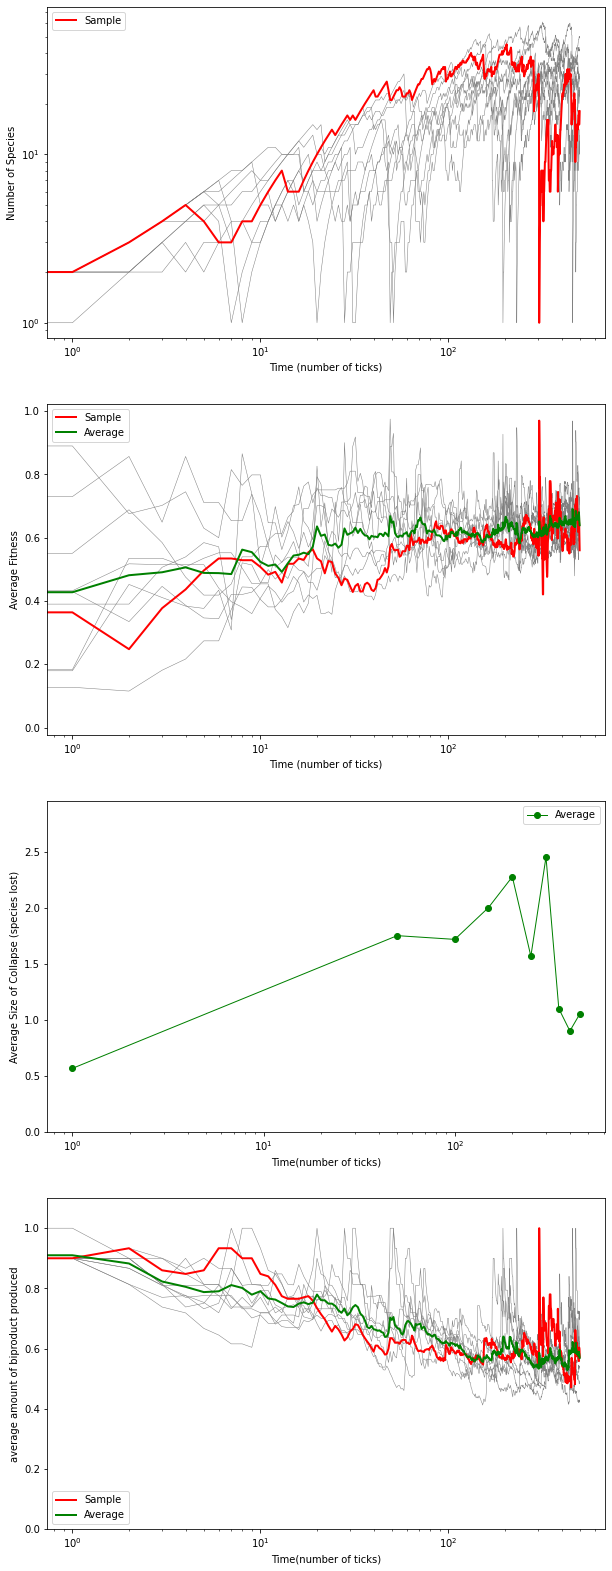

In [4]:
allfitdata = []   #the data for all ticks in all trials for average fitness that tick and trial
allfitmean = []    #the average fitness for a given tick averaged futher across all trials
fitminimean = []    #the list of all average fitnesses for a given tick across trials

alloutputdata = []   #the data for all ticks in all trials for average amount of resource produced that tick and trial
alloutputmean = []    #the average amount of resource produced for a given tick averaged futher across all trials
outputminimean = []    #the list of all average outputs for a given tick across trials

fig = plt.figure(figsize = (10, 28))    #setting up graphs and graph settings

ax = fig.add_subplot(4, 1, 1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Time (number of ticks)')
ax.set_ylabel('Number of Species')

fit = fig.add_subplot(4, 1, 2)
fit.set_xlabel('Time (number of ticks)')
fit.set_ylabel('Average Fitness')
fit.set_xscale('log')

col = fig.add_subplot(4, 1, 3)
col.set_xscale('log')
col.set_xlabel('Time(number of ticks)')
col.set_ylabel('Average Size of Collapse (species lost)')

outp = fig.add_subplot(4, 1, 4)
outp.set_ylim(0, 1.1)
outp.set_xscale('log')
outp.set_xlabel('Time(number of ticks)')
outp.set_ylabel('average amount of biproduct produced')

trials = 10
steps = 500
for i in range(trials):
    model = MicrobeModel()    #runs the model for the given number of ticks and trials
    for x in range(steps):
        model.step()
    print(i, end = ' ')    #prints the number of trials that have been completed
        
    if i == (trials - 1):    #plots data for each individual trial for the population and the output graphs
        ax.plot(agentpoplist, color = 'red', linewidth = 2, label = 'Sample')
        outp.plot(outputlist, color = 'red', linewidth = 2, label = 'Sample')
        
        
    else:
        ax.plot(agentpoplist, color = 'grey', linewidth = 0.5)
        outp.plot(outputlist, color = 'grey', linewidth = 0.5)

    allfitdata.append(agentfitnesslist)    #records data across all trials
    alloutputdata.append(outputlist)

    unusedfoods = []
    for i in range(maxresources):    #sets up the model to run for the next trial
        unusedfoods.append(i)
    random.shuffle(unusedfoods)
    usedfoods = [maxresources]
    fitness = 0.0
    agentpoplist = []
    agentfitnesslist = []
    agentfitnessdict = {}
    usedfoodspercent = {maxresources: 0}
    outputlist = []


splituplistbasic = []    #turns a single list of the size of the collapse each tick for every trial into a set of nested lists, with an individual list for each trial
for i in range(trials):
    splituplistbasic.append(collapselist[(i * steps) : ((i + 1) * steps)])
    
colmean = []    #averages the size of collapse for a given tick across trials
splituplist = []
for x in range(steps):
    for i in range(trials):
        if splituplistbasic[i][x] > 1:
            colmean.append(splituplistbasic[i][x])
    if len(colmean) > 0:
        splituplist.append(copy.copy(statistics.mean(colmean)))
    else:
        splituplist.append(0)
    colmean = []
    
bins = int(steps / 50)    #determines the number of data points for the collapse graph(this has to be relatively large as otherwise it takes too many trials to get meaningul data)

horzmean = []    #averages the size of collapse of ticks near to each other so that there arethe same number of y data points as bins
for i in range(bins):
    horzmean.append(statistics.mean(splituplist[(i * 10) : ((i + 1) * 10)]))
    
xcol = [1]    #distributes the x coordinates so that they take up an x-scale of length equal to the number of ticks
for i in range(1, bins):
    xcol.append(i * 50)
    
col.set_ylim(0, (max(horzmean) + 0.5))    #graph formatting
col.plot(xcol, horzmean, color = 'green', marker='o', linewidth = 1, label = 'Average')   #plots the average data line for the collapse graph
    
for i in range(trials):    #plots each individual fitness data line
    if i == (trials - 1):
        fit.plot(allfitdata[i], color = 'red', linewidth = 2, label = 'Sample')
    else:
        fit.plot(allfitdata[i], color = 'grey', linewidth = 0.5)

for i in range(steps):    #calculates the average data line for the fitness graph and the output graph
    for x in range(trials):
        fitminimean.append(allfitdata[x][i])
        outputminimean.append(alloutputdata[x][i])
    allfitmean.append(copy.copy(statistics.mean(fitminimean)))
    alloutputmean.append(copy.copy(statistics.mean(outputminimean)))
    fitminimean = []
    outputminimean = []
    
fit.plot(allfitmean, color = 'green', linewidth = 2, label = 'Average')    #plots the average data line for the fitness and output graphs
outp.plot(alloutputmean, color = 'green', linewidth = 2, label = 'Average')

axleg = ax.legend()
fitleg = fit.legend()
colleg = col.legend()
outpleg = outp.legend()